Using data from: /kaggle/input/stage2/data/train
Output will be saved to: /kaggle/working
Found 5628 audio files
Found 4 classes: ['backgroundnoise', 'brokenbranches', 'footsteps', 'gunshot']
Session structure:
  Session 0: ['backgroundnoise', 'brokenbranches', 'footsteps']
  Session 1: ['gunshot']

=== Session 0: Classes ['backgroundnoise', 'brokenbranches', 'footsteps'] ===
Session 0: 4221 files, 3 classes
Created new AudioResNet model with 3 classes


Calibrated base prototypes


Session 0 Epoch 5/20: 100%|██████████| 125/125 [00:11<00:00, 10.73it/s, Loss=0.5555]


Session 0 Epoch 5/20 Loss: 0.6543


Session 0 Epoch 10/20: 100%|██████████| 125/125 [00:11<00:00, 10.50it/s, Loss=0.7524]


Session 0 Epoch 10/20 Loss: 0.6244


Session 0 Epoch 15/20: 100%|██████████| 125/125 [00:12<00:00, 10.26it/s, Loss=0.8038]


Session 0 Epoch 15/20 Loss: 0.5841


Session 0 Epoch 20/20: 100%|██████████| 125/125 [00:11<00:00, 10.74it/s, Loss=0.4982]


Session 0 Epoch 20/20 Loss: 0.5587


Session 0: Accuracy 0.7264

=== Session 1: Classes ['backgroundnoise', 'brokenbranches', 'footsteps', 'gunshot'] ===
Session 1: 5628 files, 4 classes
Expanded AudioResNet model to 4 classes


Applied TEEN calibration with alpha=0.5


Session 1 Epoch 5/20: 100%|██████████| 167/167 [00:20<00:00,  8.09it/s, Loss=0.7585]


Session 1 Epoch 5/20 Loss: 0.7025


Session 1 Epoch 10/20: 100%|██████████| 167/167 [00:17<00:00,  9.53it/s, Loss=1.1272]


Session 1 Epoch 10/20 Loss: 0.6502


Session 1 Epoch 15/20: 100%|██████████| 167/167 [00:16<00:00, 10.36it/s, Loss=0.5610]


Session 1 Epoch 15/20 Loss: 0.6123


Session 1 Epoch 20/20: 100%|██████████| 167/167 [00:17<00:00,  9.79it/s, Loss=0.5216]


Session 1 Epoch 20/20 Loss: 0.5924


Session 1: Accuracy 0.7092


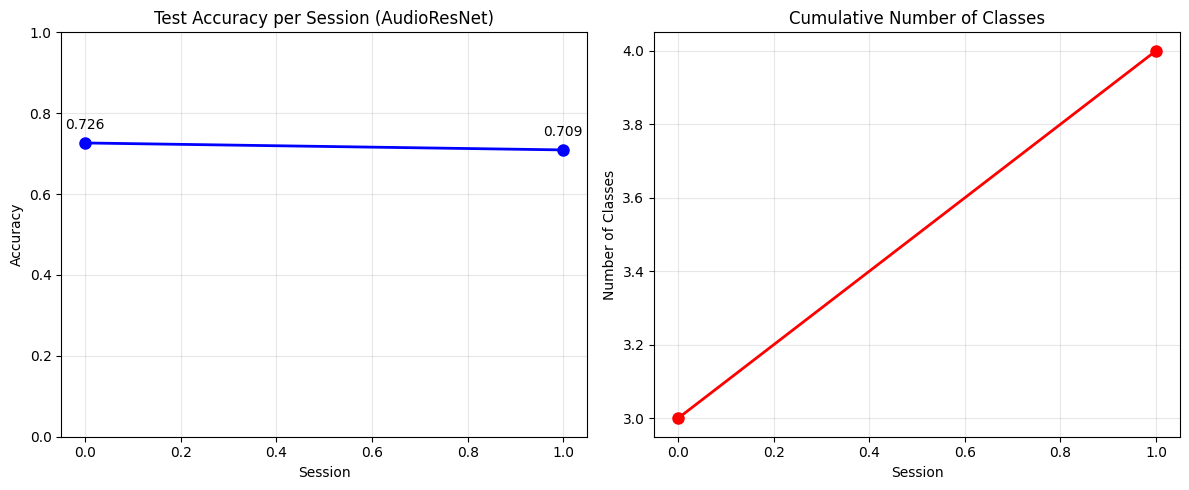


=== Final Results ===
Session 0: 3 classes, Accuracy: 0.7264
Session 1: 4 classes, Accuracy: 0.7092

Results saved to: /kaggle/working
Files created:
- results.json: Detailed results
- results_plot.png: Performance visualization
- model_session_*.pth: Model checkpoints
- train.log: Training logs


In [1]:
# Audio Classification with TEEN (Task-Embedded Entity Networks) for Incremental Learning
# Adapted for Kaggle environment with audio dataset using AudioResNet

import os
import torch
import torchaudio
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
import logging
import json
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Kaggle-specific paths
DATA_PATH = "/kaggle/input/stage2/data/train"  # Adjust this to match your dataset path
OUTPUT_PATH = "/kaggle/working"

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Dataset for audio files with class from filename
class AudioIncrementalDataset(Dataset):
    def __init__(self, file_list, label_map, transform=None, max_length=16000*3):  # 3 seconds max
        self.file_list = file_list
        self.label_map = label_map
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        try:
            file_path = self.file_list[idx]
            label_str = os.path.basename(file_path).split('_')[0]
            label = self.label_map[label_str]
            
            # Load audio file
            waveform, sr = torchaudio.load(file_path)
            
            # Handle variable length audio
            if waveform.shape[1] > self.max_length:
                # Truncate to max_length
                waveform = waveform[:, :self.max_length]
            elif waveform.shape[1] < self.max_length:
                # Pad with zeros
                pad_amount = self.max_length - waveform.shape[1]
                waveform = torch.nn.functional.pad(waveform, (0, pad_amount))
            
            if self.transform:
                features = self.transform(waveform, sr)
            else:
                features = waveform
            return features, label
        except Exception as e:
            
            # Return zero tensor and first label as fallback
            dummy_waveform = torch.zeros(1, self.max_length)
            if self.transform:
                features = self.transform(dummy_waveform, 16000)
            else:
                features = dummy_waveform
            return features, 0

# Feature extraction (Mel spectrogram with power_to_db)
def extract_features(waveform, sr=16000, n_mels=64, n_fft=1024, hop_length=512):
    # Convert to mono if stereo
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    
    # Create mel spectrogram
    mel_spec_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr, 
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length,
        power=2.0  # Use power spectrogram (magnitude squared)
    )
    mel_spec = mel_spec_transform(waveform)
    
    # Convert to dB scale using power_to_db instead of amplitude_to_db
    mel_spec_db = 10.0 * torch.log10(torch.clamp(mel_spec, min=1e-10))
    
    return mel_spec_db

# ResNet Block for Audio
class AudioResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(AudioResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.dropout = nn.Dropout2d(0.1)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# AudioResNet for audio classification
class AudioResNet(nn.Module):
    def __init__(self, num_classes, feat_dim=512):
        super(AudioResNet, self).__init__()
        self.feat_dim = feat_dim
        
        # Initial convolution
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # ResNet layers
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        
        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes, bias=False)
        
        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(AudioResBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(AudioResBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        return logits

    def extract_features(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

# TEEN-style prototype calibration
def teen_calibrate_prototypes(model, base_loader, new_loader, device, base_indices, new_indices, alpha=0.5):
    model.eval()
    
    # Get base prototypes
    base_features = defaultdict(list)
    with torch.no_grad():
        for x, y in tqdm(base_loader, desc="Computing base prototypes", leave=False):
            x, y = x.to(device), y.to(device)
            feats = model.extract_features(x)
            for f, label in zip(feats, y):
                base_features[label.item()].append(f.cpu().numpy())
    
    base_protos = []
    for idx in base_indices:
        if base_features[idx]:
            proto = np.mean(base_features[idx], axis=0)
        else:
            proto = np.zeros(model.feat_dim)
        base_protos.append(proto)
    base_protos = np.stack(base_protos)
    base_protos_torch = torch.tensor(base_protos, dtype=torch.float, device=device)
    base_protos_torch = F.normalize(base_protos_torch, p=2, dim=1)

    # Get new prototypes
    new_features = defaultdict(list)
    with torch.no_grad():
        for x, y in tqdm(new_loader, desc="Computing new prototypes", leave=False):
            x, y = x.to(device), y.to(device)
            feats = model.extract_features(x)
            for f, label in zip(feats, y):
                new_features[label.item()].append(f.cpu().numpy())
    
    new_protos = []
    for idx in new_indices:
        if new_features[idx]:
            proto = np.mean(new_features[idx], axis=0)
        else:
            proto = np.zeros(model.feat_dim)
        new_protos.append(proto)
    new_protos = np.stack(new_protos)
    new_protos_torch = torch.tensor(new_protos, dtype=torch.float, device=device)
    new_protos_torch = F.normalize(new_protos_torch, p=2, dim=1)

    # Compute similarity between new and base prototypes
    sim = torch.mm(new_protos_torch, base_protos_torch.t())  # (num_new, num_base)
    sim_weights = F.softmax(sim, dim=1)  # weights for base prototypes

    # Fuse new prototypes with weighted base prototypes
    fused_new_protos = (1 - alpha) * new_protos_torch + alpha * torch.mm(sim_weights, base_protos_torch)
    fused_new_protos = F.normalize(fused_new_protos, p=2, dim=1)

    # Update classifier weights
    with torch.no_grad():
        # base weights
        model.fc.weight[:len(base_indices)] = base_protos_torch
        # new weights
        model.fc.weight[len(base_indices):len(base_indices)+len(new_indices)] = fused_new_protos

# Trainer class (TEEN-style with AudioResNet)
class AudioTEENTrainer:
    def __init__(self, data_dir, save_dir, base_classes=3, new_classes_per_session=2, 
                 epochs=15, batch_size=32, lr=1e-3, alpha=0.5, seed=42, device='cuda'):
        self.data_dir = data_dir
        self.save_dir = save_dir
        self.base_classes = base_classes
        self.new_classes_per_session = new_classes_per_session
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.alpha = alpha
        self.seed = seed
        self.device = device if torch.cuda.is_available() else 'cpu'
        
        set_seed(seed)
        self.prepare_logging()
        self.prepare_data()
        self.model = None
        self.results = []

    def prepare_logging(self):
        os.makedirs(self.save_dir, exist_ok=True)
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s %(levelname)s %(message)s',
            handlers=[
                logging.FileHandler(os.path.join(self.save_dir, 'train.log')),
                logging.StreamHandler()
            ]
        )

    def prepare_data(self):
        # Get all .wav files
        files = [os.path.join(self.data_dir, f) for f in os.listdir(self.data_dir) 
                if f.endswith('.wav') and os.path.isfile(os.path.join(self.data_dir, f))]
        
        print(f"Found {len(files)} audio files")
        
        # Extract unique labels from filenames
        labels = sorted({os.path.basename(f).split('_')[0] for f in files})
        print(f"Found {len(labels)} classes: {labels}")
        
        self.labels = labels
        self.label_map_full = {label: idx for idx, label in enumerate(labels)}
        
        # Split classes into sessions
        self.class_sessions = [labels[:self.base_classes]]
        for i in range(self.base_classes, len(labels), self.new_classes_per_session):
            self.class_sessions.append(labels[i:i+self.new_classes_per_session])
        
        self.files = files
        
        print(f"Session structure:")
        for i, session in enumerate(self.class_sessions):
            print(f"  Session {i}: {session}")

    def run(self):
        seen_classes = []
        self.model = None
        session_accuracies = []
        
        for session_idx, session_classes in enumerate(self.class_sessions):
            seen_classes += session_classes
            print(f"\n=== Session {session_idx}: Classes {seen_classes} ===")
            
            # Get files for current session (all seen classes)
            session_files = [f for f in self.files if os.path.basename(f).split('_')[0] in seen_classes]
            session_label_map = {label: idx for idx, label in enumerate(seen_classes)}
            class_indices = list(range(len(seen_classes)))
            
            print(f"Session {session_idx}: {len(session_files)} files, {len(seen_classes)} classes")

            # Split train/test
            train_files, test_files = train_test_split(session_files, test_size=0.05, 
                                                     random_state=self.seed, stratify=[os.path.basename(f).split('_')[0] for f in session_files])
            
            train_dataset = AudioIncrementalDataset(train_files, session_label_map, transform=extract_features)
            test_dataset = AudioIncrementalDataset(test_files, session_label_map, transform=extract_features)
            train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, 
                                    drop_last=len(train_dataset) > self.batch_size, num_workers=2)
            test_loader = DataLoader(test_dataset, batch_size=self.batch_size, num_workers=2)

            # Model initialization or expansion
            if self.model is None:
                self.model = AudioResNet(num_classes=len(seen_classes)).to(self.device)
                print(f"Created new AudioResNet model with {len(seen_classes)} classes")
            else:
                # Expand classifier for new classes
                old_fc = self.model.fc
                self.model.fc = nn.Linear(512, len(seen_classes), bias=False).to(self.device)  # 512 is AudioResNet feat_dim
                with torch.no_grad():
                    # Copy old weights
                    self.model.fc.weight[:old_fc.out_features] = old_fc.weight
                    # Initialize new weights randomly
                    nn.init.xavier_normal_(self.model.fc.weight[old_fc.out_features:])
                print(f"Expanded AudioResNet model to {len(seen_classes)} classes")

            # TEEN-style prototype calibration
            if session_idx == 0:
                # Base session: compute base prototypes
                self.calibrate_base_prototypes(train_loader, class_indices)
                print("Calibrated base prototypes")
            else:
                # Incremental: fuse new with base
                base_indices = list(range(len(seen_classes) - len(session_classes)))
                new_indices = list(range(len(seen_classes) - len(session_classes), len(seen_classes)))
                
                # Create separate loaders for base and new classes
                base_class_names = [seen_classes[i] for i in base_indices]
                new_class_names = [seen_classes[i] for i in new_indices]
                
                base_files = [f for f in train_files if os.path.basename(f).split('_')[0] in base_class_names]
                new_files = [f for f in train_files if os.path.basename(f).split('_')[0] in new_class_names]
                
                base_dataset = AudioIncrementalDataset(base_files, session_label_map, transform=extract_features)
                new_dataset = AudioIncrementalDataset(new_files, session_label_map, transform=extract_features)
                base_loader = DataLoader(base_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)
                new_loader = DataLoader(new_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)
                
                teen_calibrate_prototypes(self.model, base_loader, new_loader, self.device, 
                                        base_indices, new_indices, alpha=self.alpha)
                print(f"Applied TEEN calibration with alpha={self.alpha}")

            # Training loop
            optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=1e-4)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
            criterion = nn.CrossEntropyLoss()
            
            self.model.train()
            epoch_losses = []
            
            for epoch in range(self.epochs):
                total_loss = 0
                num_batches = 0
                
                progress_bar = tqdm(train_loader, desc=f"Session {session_idx} Epoch {epoch+1}/{self.epochs}")
                for x, y in progress_bar:
                    x, y = x.to(self.device), y.to(self.device)
                    
                    optimizer.zero_grad()
                    out = self.model(x)
                    loss = criterion(out, y)
                    loss.backward()
                    
                    # Gradient clipping
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                    
                    optimizer.step()
                    
                    total_loss += loss.item()
                    num_batches += 1
                    progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})
                
                avg_loss = total_loss / num_batches if num_batches > 0 else 0
                epoch_losses.append(avg_loss)
                scheduler.step(avg_loss)
                
                if (epoch + 1) % 5 == 0:
                    print(f"Session {session_idx} Epoch {epoch+1}/{self.epochs} Loss: {avg_loss:.4f}")

            # Evaluation
            acc = self.evaluate(test_loader)
            session_accuracies.append(acc)
            print(f"Session {session_idx}: Accuracy {acc:.4f}")
            
            self.results.append({
                'session': session_idx,
                'classes': seen_classes.copy(),
                'accuracy': acc,
                'num_classes': len(seen_classes),
                'new_classes': session_classes
            })
            
            # Save model checkpoint
            torch.save({
                'model_state_dict': self.model.state_dict(),
                'session': session_idx,
                'classes': seen_classes,
                'accuracy': acc
            }, os.path.join(self.save_dir, f"model_session_{session_idx}.pth"))
            
            # Save results
            with open(os.path.join(self.save_dir, 'results.json'), 'w') as f:
                json.dump(self.results, f, indent=2)
        
        # Plot results
        self.plot_results(session_accuracies)
        return self.results

    def calibrate_base_prototypes(self, loader, class_indices):
        self.model.eval()
        features = defaultdict(list)
        
        with torch.no_grad():
            for x, y in tqdm(loader, desc="Calibrating base prototypes", leave=False):
                x, y = x.to(self.device), y.to(self.device)
                feats = self.model.extract_features(x)
                for f, label in zip(feats, y):
                    features[label.item()].append(f.cpu().numpy())
        
        weight_matrix = []
        for class_idx in class_indices:
            if features[class_idx]:
                proto = np.mean(features[class_idx], axis=0)
            else:
                proto = np.zeros(self.model.feat_dim)
            weight_matrix.append(proto)
        
        weight_matrix = torch.tensor(np.stack(weight_matrix), dtype=torch.float)
        weight_matrix = F.normalize(weight_matrix, p=2, dim=1)
        
        with torch.no_grad():
            self.model.fc.weight[:len(class_indices)] = weight_matrix.to(self.model.fc.weight.device)

    def evaluate(self, loader):
        self.model.eval()
        correct, total = 0, 0
        
        with torch.no_grad():
            for x, y in tqdm(loader, desc="Evaluating", leave=False):
                x, y = x.to(self.device), y.to(self.device)
                out = self.model(x)
                pred = out.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        
        return correct / total if total > 0 else 0.0

    def plot_results(self, session_accuracies):
        plt.figure(figsize=(12, 5))
        
        # Plot 1: Session accuracy
        plt.subplot(1, 2, 1)
        sessions = list(range(len(session_accuracies)))
        plt.plot(sessions, session_accuracies, 'bo-', linewidth=2, markersize=8)
        plt.xlabel('Session')
        plt.ylabel('Accuracy')
        plt.title('Test Accuracy per Session (AudioResNet)')
        plt.grid(True, alpha=0.3)
        plt.ylim(0, 1)
        
        # Add accuracy values on points
        for i, acc in enumerate(session_accuracies):
            plt.annotate(f'{acc:.3f}', (i, acc), textcoords="offset points", 
                        xytext=(0,10), ha='center')
        
        # Plot 2: Cumulative classes
        plt.subplot(1, 2, 2)
        cumulative_classes = [len(result['classes']) for result in self.results]
        plt.plot(sessions, cumulative_classes, 'ro-', linewidth=2, markersize=8)
        plt.xlabel('Session')
        plt.ylabel('Number of Classes')
        plt.title('Cumulative Number of Classes')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'results_plot.png'), dpi=300, bbox_inches='tight')
        plt.show()

# Main execution
if __name__ == "__main__":
    # Check if data directory exists
    if not os.path.exists(DATA_PATH):
        print(f"Data directory {DATA_PATH} not found!")
        print("Please update DATA_PATH to match your dataset location")
    else:
        print(f"Using data from: {DATA_PATH}")
        print(f"Output will be saved to: {OUTPUT_PATH}")
        
        # Initialize trainer
        trainer = AudioTEENTrainer(
            data_dir=DATA_PATH,
            save_dir=OUTPUT_PATH,
            base_classes=3,          # Number of classes in first session
            new_classes_per_session=2,  # Classes added per incremental session
            epochs=20,               # Training epochs per session
            batch_size=32,           # Batch size
            lr=1e-3,                 # Learning rate
            alpha=0.5,               # TEEN fusion parameter
            seed=42,                 # Random seed
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )
        
        # Run training
        results = trainer.run()
        
        # Print final results
        print("\n=== Final Results ===")
        for result in results:
            print(f"Session {result['session']}: {result['num_classes']} classes, "
                  f"Accuracy: {result['accuracy']:.4f}")
        
        print(f"\nResults saved to: {OUTPUT_PATH}")
        print("Files created:")
        print("- results.json: Detailed results")
        print("- results_plot.png: Performance visualization")
        print("- model_session_*.pth: Model checkpoints")
        print("- train.log: Training logs")

In [2]:
pip install codecarbon --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 1.3 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 5.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.21.1 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.
firebase-admin 6.9.0 requires httpx[http2]==0.28.1, but you have httpx 0.27.2 which is incompatible.
langchain-core 0.3.66 requires packaging<25,>=23.2, but you have packaging 25.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


=== Audio TEEN AudioResNet Model Evaluation ===
Found 2 sessions
Final session has 4 classes: ['backgroundnoise', 'brokenbranches', 'footsteps', 'gunshot']
Using 1528 test files

--- Evaluating Final AudioResNet Model ---


[codecarbon WARNING @ 18:08:38] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 18:08:38] [setup] RAM Tracking...
[codecarbon INFO @ 18:08:38] [setup] CPU Tracking...


Loaded AudioResNet model from session 1
Model accuracy from training: 0.7092


[codecarbon WARNING @ 18:08:39] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 18:08:39] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 18:08:39] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 18:08:39] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 18:08:39] [setup] GPU Tracking...
[codecarbon INFO @ 18:08:39] Tracking Nvidia GPU via pynvml
[codecarbon WARNING @ 18:08:39] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


=== Prediction Performance Metrics ===
Prediction time: 7029.3579 m.seconds
Energy consumption: 16.952740 mg CO2 equivalent
Samples processed: 1528
Time per sample: 4.60 ms
Energy per sample: 0.011095 mg CO2 eq


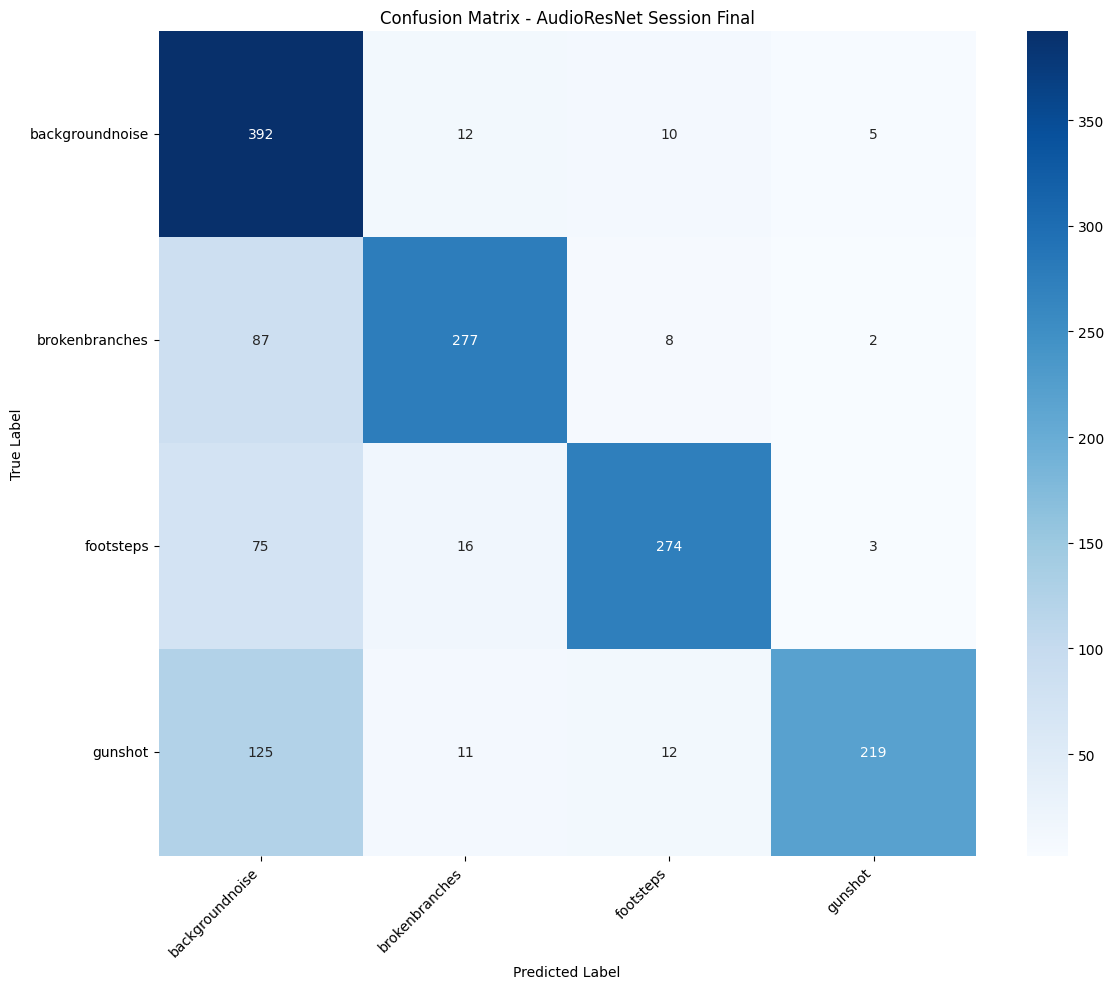

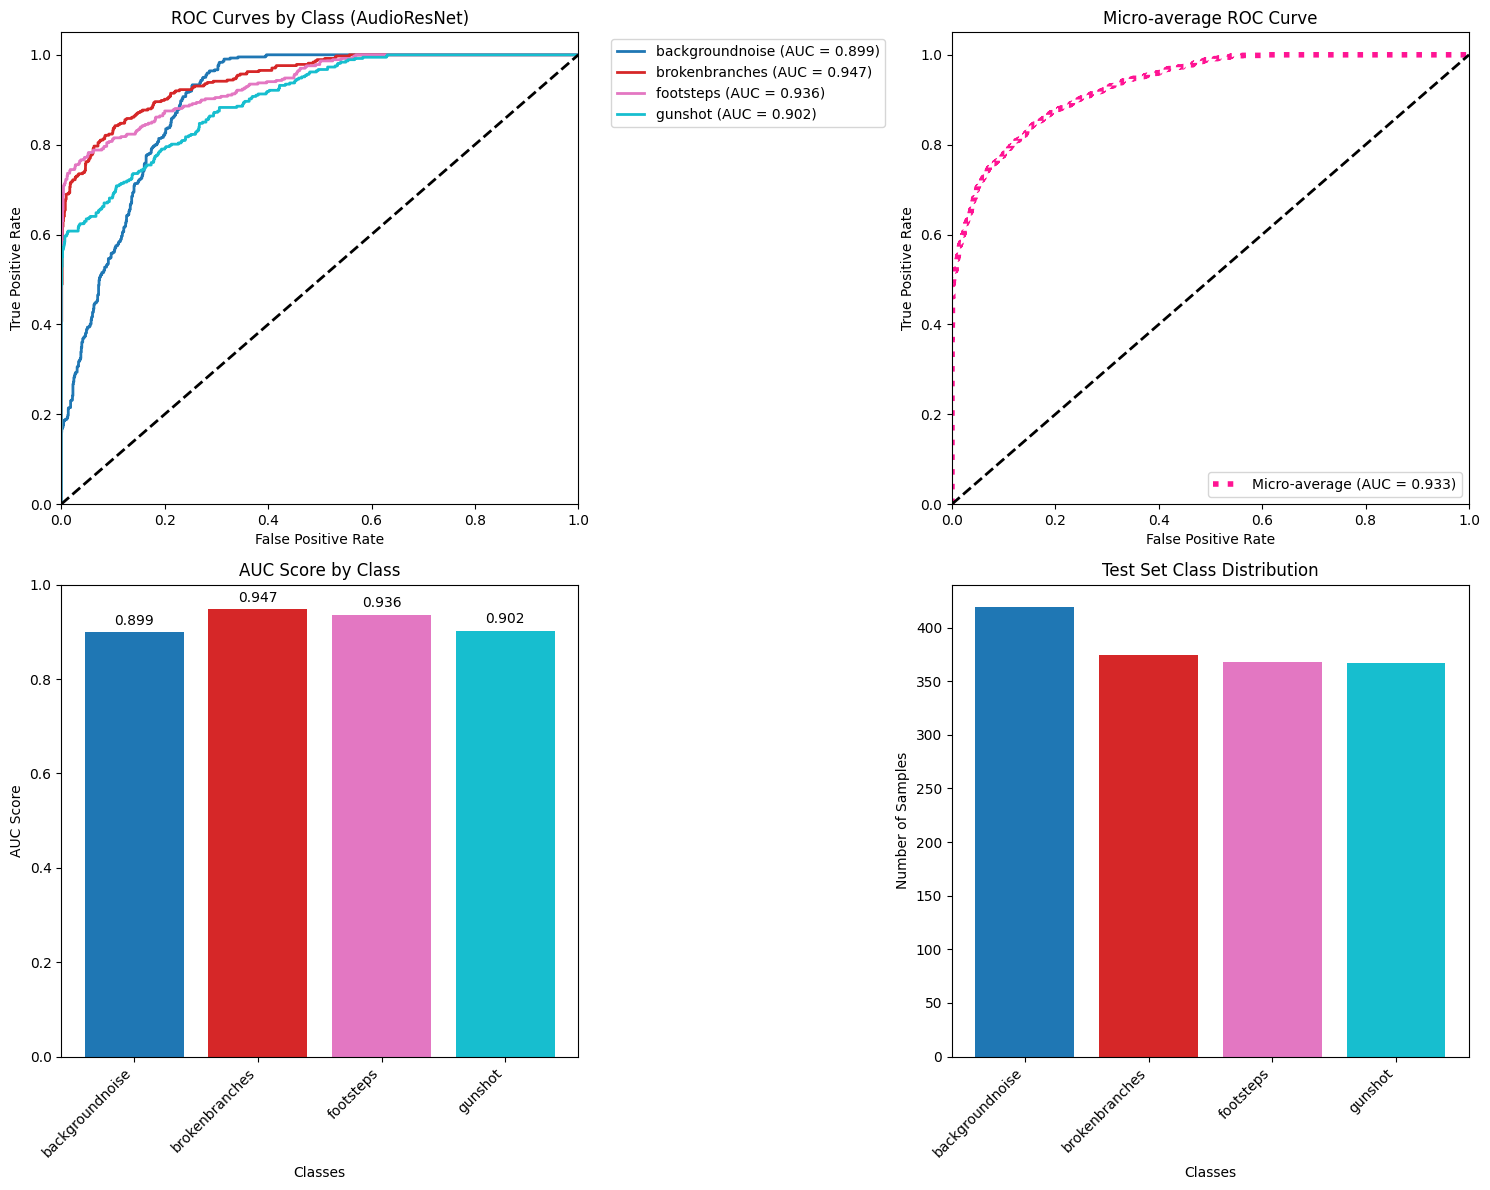


Classification Report - AudioResNet Session Final:
                 precision  recall  f1-score    support
backgroundnoise     0.5773  0.9356    0.7140   419.0000
brokenbranches      0.8766  0.7406    0.8029   374.0000
footsteps           0.9013  0.7446    0.8155   368.0000
gunshot             0.9563  0.5967    0.7349   367.0000
accuracy            0.7605  0.7605    0.7605     0.7605
macro avg           0.8279  0.7544    0.7668  1528.0000
weighted avg        0.8196  0.7605    0.7652  1528.0000

=== Evaluation Complete ===
Results saved to: /kaggle/working
Generated files:
- confusion_matrix_*.png: Confusion matrices
- roc_curves_*.png: ROC curves and AUC analysis
- classification_report_*.csv: Detailed metrics
- evaluation_results.json: Complete evaluation data
- energy_tracking_results.json: Energy consumption metrics

Final AudioResNet Model Performance:
Test Accuracy: 0.7605
Macro AUC: 0.9211
Micro AUC: 0.9325
Number of classes: 4
Classes: ['backgroundnoise', 'brokenbranches', 'foo

In [3]:
import os
import torch
import torchaudio
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
import warnings
import time
from codecarbon import EmissionsTracker
warnings.filterwarnings('ignore')

# Kaggle paths
DATA_PATH = "/kaggle/input/stage2/data/test"  # Your dataset path
MODEL_PATH = "/kaggle/working"  # Where models are saved
OUTPUT_PATH = "/kaggle/working"  # Where to save evaluation results

# ResNet Block for Audio (must match training code)
class AudioResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(AudioResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.dropout = nn.Dropout2d(0.1)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# AudioResNet for audio classification (must match training code)
class AudioResNet(nn.Module):
    def __init__(self, num_classes, feat_dim=512):
        super(AudioResNet, self).__init__()
        self.feat_dim = feat_dim
        
        # Initial convolution
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # ResNet layers
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        
        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes, bias=False)
        
        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(AudioResBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(AudioResBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        return logits

    def extract_features(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

# Copy dataset class (must match training code)
class AudioIncrementalDataset(Dataset):
    def __init__(self, file_list, label_map, transform=None, max_length=16000*3):
        self.file_list = file_list
        self.label_map = label_map
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        try:
            file_path = self.file_list[idx]
            label_str = os.path.basename(file_path).split('_')[0]
            label = self.label_map[label_str]
            
            waveform, sr = torchaudio.load(file_path)
            
            if waveform.shape[1] > self.max_length:
                waveform = waveform[:, :self.max_length]
            elif waveform.shape[1] < self.max_length:
                pad_amount = self.max_length - waveform.shape[1]
                waveform = torch.nn.functional.pad(waveform, (0, pad_amount))
            
            if self.transform:
                features = self.transform(waveform, sr)
            else:
                features = waveform
            return features, label
        except Exception as e:
            
            dummy_waveform = torch.zeros(1, self.max_length)
            if self.transform:
                features = self.transform(dummy_waveform, 16000)
            else:
                features = dummy_waveform
            return features, 0

# Updated feature extraction function (must match training code - power_to_db)
def extract_features(waveform, sr=16000, n_mels=64, n_fft=1024, hop_length=512):
    # Convert to mono if stereo
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    
    # Create mel spectrogram with power=2.0
    mel_spec_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr, 
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length,
        power=2.0  # Use power spectrogram (magnitude squared)
    )
    mel_spec = mel_spec_transform(waveform)
    
    # Convert to dB scale using power_to_db instead of amplitude_to_db
    mel_spec_db = 10.0 * torch.log10(torch.clamp(mel_spec, min=1e-10))
    
    return mel_spec_db

class AudioModelEvaluator:
    def __init__(self, data_dir, model_dir, device='cuda'):
        self.data_dir = data_dir
        self.model_dir = model_dir
        self.device = device if torch.cuda.is_available() else 'cpu'
        self.load_results()
        self.prepare_data()
        
    def load_results(self):
        """Load training results to get class information"""
        results_path = os.path.join(self.model_dir, 'results.json')
        if not os.path.exists(results_path):
            raise FileNotFoundError(f"Results file not found: {results_path}")
        
        with open(results_path, 'r') as f:
            self.results = json.load(f)
        
        # Get the final session info
        self.final_session = max(self.results, key=lambda x: x['session'])
        self.all_classes = self.final_session['classes']
        self.num_classes = len(self.all_classes)
        
        print(f"Found {len(self.results)} sessions")
        print(f"Final session has {self.num_classes} classes: {self.all_classes}")
        
    def prepare_data(self):
        """Prepare test data for evaluation"""
        # Get all audio files
        files = [os.path.join(self.data_dir, f) for f in os.listdir(self.data_dir) 
                if f.endswith('.wav') and os.path.isfile(os.path.join(self.data_dir, f))]
        
        # Filter files for classes we have
        files = [f for f in files if os.path.basename(f).split('_')[0] in self.all_classes]
        
        # Create label map
        self.label_map = {label: idx for idx, label in enumerate(self.all_classes)}
        
        # Same train-test split as training (important for consistency)
        train_files, test_files = train_test_split(files, test_size=0.95, random_state=42,
                                                 stratify=[os.path.basename(f).split('_')[0] for f in files])
        
        self.test_files = test_files
        print(f"Using {len(test_files)} test files")
        
    def load_model(self, session_idx=None):
        """Load AudioResNet model from specific session (default: latest)"""
        if session_idx is None:
            session_idx = self.final_session['session']
            
        model_path = os.path.join(self.model_dir, f'model_session_{session_idx}.pth')
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model file not found: {model_path}")
        
        # Load checkpoint
        checkpoint = torch.load(model_path, map_location=self.device)
        
        # Create AudioResNet model with correct number of classes
        model = AudioResNet(num_classes=self.num_classes).to(self.device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        
        print(f"Loaded AudioResNet model from session {session_idx}")
        print(f"Model accuracy from training: {checkpoint.get('accuracy', 'N/A'):.4f}")
        
        return model
    
    def evaluate_model(self, model, return_predictions=True):
        """Evaluate model and return predictions, probabilities, and true labels with energy tracking"""
        # Create test dataset and dataloader
        test_dataset = AudioIncrementalDataset(self.test_files, self.label_map, transform=extract_features)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
        
        all_predictions = []
        all_probabilities = []
        all_labels = []
        all_features = []
        
        model.eval()
        
        # === Track Energy + Time for Prediction ===
        tracker = EmissionsTracker(project_name="AudioResNet_TEEN_Evaluation")
        tracker.start()
        start_time = time.time()
        
        with torch.no_grad():
            for x, y in tqdm(test_loader, desc="Evaluating model"):
                x, y = x.to(self.device), y.to(self.device)
                
                # Get predictions
                logits = model(x)
                probabilities = F.softmax(logits, dim=1)
                predictions = logits.argmax(dim=1)
                
                # Get features if needed
                if return_predictions:
                    features = model.extract_features(x)
                    all_features.extend(features.cpu().numpy())
                
                all_predictions.extend(predictions.cpu().numpy())
                all_probabilities.extend(probabilities.cpu().numpy())
                all_labels.extend(y.cpu().numpy())
        
        # Stop tracking
        prediction_time = time.time() - start_time
        emissions = tracker.stop()
        
        # Log energy and time metrics
        print(f"\n=== Prediction Performance Metrics ===")
        print(f"Prediction time: {prediction_time*1000:.4f} m.seconds")
        print(f"Energy consumption: {emissions*1000000:.6f} mg CO2 equivalent")
        print(f"Samples processed: {len(all_predictions)}")
        print(f"Time per sample: {prediction_time/len(all_predictions)*1000:.2f} ms")
        print(f"Energy per sample: {emissions/len(all_predictions)*1000000:.6f} mg CO2 eq")
        
        # Save energy tracking results
        energy_results = {
            'prediction_time_seconds': prediction_time,
            'energy_consumption_kg_co2': emissions,
            'samples_processed': len(all_predictions),
            'time_per_sample_ms': prediction_time/len(all_predictions)*1000,
            'energy_per_sample_mg_co2': emissions/len(all_predictions)*1000000,
            'device': str(self.device),
            'model_type': 'AudioResNet'
        }
        
        with open(os.path.join(OUTPUT_PATH, 'energy_tracking_results.json'), 'w') as f:
            json.dump(energy_results, f, indent=2)
        
        return (np.array(all_predictions), np.array(all_probabilities), 
                np.array(all_labels), np.array(all_features) if return_predictions else None)
    
    def plot_confusion_matrix(self, y_true, y_pred, session_idx=None):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=self.all_classes, 
                   yticklabels=self.all_classes)
        plt.title(f'Confusion Matrix - AudioResNet Session {session_idx if session_idx else "Final"}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        
        # Save plot
        save_path = os.path.join(OUTPUT_PATH, f'confusion_matrix_session_{session_idx if session_idx else "final"}.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        return cm
    
    def plot_roc_curves(self, y_true, y_prob, session_idx=None):
        """Plot ROC curves for multiclass classification"""
        # Binarize labels for multiclass ROC
        y_true_bin = label_binarize(y_true, classes=list(range(self.num_classes)))
        
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(self.num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        # Plot ROC curves
        plt.figure(figsize=(15, 12))
        
        # Plot individual class ROC curves
        plt.subplot(2, 2, 1)
        colors = plt.cm.tab10(np.linspace(0, 1, self.num_classes))
        for i, color in zip(range(self.num_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                    label=f'{self.all_classes[i]} (AUC = {roc_auc[i]:.3f})')
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves by Class (AudioResNet)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Plot micro-average ROC curve
        plt.subplot(2, 2, 2)
        plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
                label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Micro-average ROC Curve')
        plt.legend()
        
        # AUC scores bar plot
        plt.subplot(2, 2, 3)
        auc_scores = [roc_auc[i] for i in range(self.num_classes)]
        bars = plt.bar(self.all_classes, auc_scores, color=colors)
        plt.xlabel('Classes')
        plt.ylabel('AUC Score')
        plt.title('AUC Score by Class')
        plt.xticks(rotation=45, ha='right')
        plt.ylim([0, 1])
        
        # Add value labels on bars
        for bar, score in zip(bars, auc_scores):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontsize=10)
        
        # Class distribution
        plt.subplot(2, 2, 4)
        class_counts = np.bincount(y_true)
        plt.bar(self.all_classes, class_counts, color=colors)
        plt.xlabel('Classes')
        plt.ylabel('Number of Samples')
        plt.title('Test Set Class Distribution')
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        
        # Save plot
        save_path = os.path.join(OUTPUT_PATH, f'roc_curves_session_{session_idx if session_idx else "final"}.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        return roc_auc
    
    def generate_classification_report(self, y_true, y_pred, session_idx=None):
        """Generate and save detailed classification report"""
        report = classification_report(y_true, y_pred, 
                                     target_names=self.all_classes,
                                     output_dict=True)
        
        # Convert to DataFrame for better visualization
        df_report = pd.DataFrame(report).transpose()
        
        print(f"\nClassification Report - AudioResNet Session {session_idx if session_idx else 'Final'}:")
        print("="*60)
        print(df_report.round(4))
        
        # Save report
        save_path = os.path.join(OUTPUT_PATH, f'classification_report_session_{session_idx if session_idx else "final"}.csv')
        df_report.to_csv(save_path)
        
        return df_report
    
    def evaluate_all_sessions(self):
        """Evaluate all saved sessions"""
        print("Evaluating all sessions...")
        
        all_session_results = []
        
        for session_info in self.results:
            session_idx = session_info['session']
            
            try:
                print(f"\n--- Evaluating Session {session_idx} ---")
                
                # Load model for this session
                model = self.load_model(session_idx)
                
                # Evaluate
                y_pred, y_prob, y_true, features = self.evaluate_model(model)
                
                # Generate metrics
                cm = self.plot_confusion_matrix(y_true, y_pred, session_idx)
                roc_auc = self.plot_roc_curves(y_true, y_prob, session_idx)
                report = self.generate_classification_report(y_true, y_pred, session_idx)
                
                # Store results
                session_result = {
                    'session': session_idx,
                    'accuracy': np.mean(y_pred == y_true),
                    'auc_scores': {self.all_classes[i]: roc_auc[i] for i in range(len(self.all_classes)) if i in roc_auc},
                    'macro_auc': np.mean([roc_auc[i] for i in range(len(self.all_classes)) if i in roc_auc]),
                    'micro_auc': roc_auc.get('micro', 0),
                    'num_classes': len(session_info['classes'])
                }
                
                all_session_results.append(session_result)
                
            except Exception as e:
                print(f"Error evaluating session {session_idx}: {e}")
                continue
        
        # Save comprehensive results
        with open(os.path.join(OUTPUT_PATH, 'evaluation_results.json'), 'w') as f:
            json.dump(all_session_results, f, indent=2)
        
        # Plot session comparison
        self.plot_session_comparison(all_session_results)
        
        return all_session_results
    
    def plot_session_comparison(self, session_results):
        """Plot comparison across sessions"""
        sessions = [r['session'] for r in session_results]
        accuracies = [r['accuracy'] for r in session_results]
        macro_aucs = [r['macro_auc'] for r in session_results]
        micro_aucs = [r['micro_auc'] for r in session_results]
        num_classes = [r['num_classes'] for r in session_results]
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Accuracy across sessions
        axes[0, 0].plot(sessions, accuracies, 'bo-', linewidth=2, markersize=8)
        axes[0, 0].set_xlabel('Session')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].set_title('Test Accuracy Across Sessions (AudioResNet)')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].set_ylim(0, 1)
        
        # AUC scores across sessions
        axes[0, 1].plot(sessions, macro_aucs, 'ro-', label='Macro AUC', linewidth=2, markersize=8)
        axes[0, 1].plot(sessions, micro_aucs, 'go-', label='Micro AUC', linewidth=2, markersize=8)
        axes[0, 1].set_xlabel('Session')
        axes[0, 1].set_ylabel('AUC Score')
        axes[0, 1].set_title('AUC Scores Across Sessions')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].set_ylim(0, 1)
        
        # Number of classes
        axes[1, 0].plot(sessions, num_classes, 'mo-', linewidth=2, markersize=8)
        axes[1, 0].set_xlabel('Session')
        axes[1, 0].set_ylabel('Number of Classes')
        axes[1, 0].set_title('Cumulative Classes Across Sessions')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Performance vs complexity
        axes[1, 1].scatter(num_classes, accuracies, c=sessions, cmap='viridis', s=100)
        axes[1, 1].set_xlabel('Number of Classes')
        axes[1, 1].set_ylabel('Accuracy')
        axes[1, 1].set_title('Accuracy vs Model Complexity')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Add colorbar for session info
        cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
        cbar.set_label('Session')
        
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_PATH, 'session_comparison.png'), dpi=300, bbox_inches='tight')
        plt.show()

# Main execution
if __name__ == "__main__":
    print("=== Audio TEEN AudioResNet Model Evaluation ===")
    
    # Check if required files exist
    if not os.path.exists(DATA_PATH):
        print(f"Data directory not found: {DATA_PATH}")
        print("Please update DATA_PATH to match your dataset location")
    elif not os.path.exists(os.path.join(MODEL_PATH, 'results.json')):
        print(f"Results file not found: {os.path.join(MODEL_PATH, 'results.json')}")
        print("Please run the training script first")
    else:
        # Initialize evaluator
        evaluator = AudioModelEvaluator(
            data_dir=DATA_PATH,
            model_dir=MODEL_PATH,
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )
        
        # Option 1: Evaluate only the final/latest model
        print("\n--- Evaluating Final AudioResNet Model ---")
        model = evaluator.load_model()  # Loads latest session
        y_pred, y_prob, y_true, features = evaluator.evaluate_model(model)
        
        # Generate all metrics for final model
        cm = evaluator.plot_confusion_matrix(y_true, y_pred)
        roc_auc = evaluator.plot_roc_curves(y_true, y_prob)
        report = evaluator.generate_classification_report(y_true, y_pred)
        
        # Option 2: Evaluate all sessions (uncomment if you want this)
        # session_results = evaluator.evaluate_all_sessions()
        
        print("\n=== Evaluation Complete ===")
        print(f"Results saved to: {OUTPUT_PATH}")
        print("Generated files:")
        print("- confusion_matrix_*.png: Confusion matrices")
        print("- roc_curves_*.png: ROC curves and AUC analysis")
        print("- classification_report_*.csv: Detailed metrics")
        print("- evaluation_results.json: Complete evaluation data")
        print("- energy_tracking_results.json: Energy consumption metrics")
        
        # Print summary statistics
        print(f"\nFinal AudioResNet Model Performance:")
        print(f"Test Accuracy: {np.mean(y_pred == y_true):.4f}")
        print(f"Macro AUC: {np.mean(list(roc_auc.values())[:len(evaluator.all_classes)]):.4f}")
        print(f"Micro AUC: {roc_auc.get('micro', 0):.4f}")
        print(f"Number of classes: {evaluator.num_classes}")
        print(f"Classes: {evaluator.all_classes}")